In [1]:
from typing import Any
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import numpy as np

import hodel


class Triplet(hodel.EnergyModel):
    """3 node spring where Theta is [K_1, K_2]"""

    def __init__(self, xf0, xb0):
        x0 = xb0[0]
        x1, x2 = xf0
        self.l_k = jnp.array([x1 - x0, x2 - x1])

    @staticmethod
    def get_strain(x0, x1, x2, l_k) -> jax.Array:
        return jnp.array([x1 - x0, x2 - x1]) / l_k
    
    def get_K(self, del_strain: jax.Array, Theta: jax.Array) -> jax.Array:
        return jnp.diag(jnp.abs(Theta))

    def get_energy(
        self,
        xf: jax.Array,
        xb: jax.Array = jnp.array([]),
        Theta: jax.Array = jnp.array([]),
        aux=None,
    ) -> jax.Array:
        # xb = [x0], xf = [x1, x2]
        x0 = xb[0]
        x1, x2 = xf
        del_strain = self.get_strain(x0, x1, x2, self.l_k) - 1.0
        return 0.5 * del_strain @ self.get_K(del_strain, Theta) @ del_strain

class LinearForce(hodel.ExternalForce):
    """ Linear force with offset """
    def __init__(self, f: jax.Array, c: jax.Array) -> None:
        self.f = f  # shape matches xf
        self.c = c

    def get_grad_energy(self, lambda_: jax.Array, aux: Any = None) -> jax.Array:
        return lambda_* self.f + self.c


def fixed_0(lambda_: jax.Array, _ = None) -> jax.Array:
    return jnp.array([0.0])

# Setup
xf0 = jnp.array([1.0, 2.0])
energy = Triplet(xf0, fixed_0(jnp.array([0.0])))
force = LinearForce(jnp.array([0.0, 20.0]), jnp.array([0.0, 9.81]))
sim = hodel.HODEL(energy, [force], fixed_0)

key = jax.random.PRNGKey(0)
Theta_star = jnp.array([5.0, 2.0])
lambdas = jnp.linspace(0, 1, 10)

print("λ=0: ", sim.solve(jnp.array([0.0]), xf0, Theta_star))
print("λ=1: ", sim.solve(jnp.array([1.0]), xf0, Theta_star))

λ=0:  [2.9620001 8.867001 ]
λ=1:  [ 6.9620004 22.867    ]


In [2]:
xf_stars = sim.sim(lambdas, xf0, Theta_star)
Theta0 = jax.random.uniform(key, [2], minval=1e-1, maxval=1e1)
lr = 1e-1
n_epochs = 100

final_Theta, L = sim.learn(
    lambdas, xf0, xf_stars, Theta0, optim=optax.adam(lr), n_epochs=n_epochs
)

print("True Theta:", Theta_star)
print("Theta0:", Theta0)
print("Final Theta:", final_Theta)

True Theta: [5. 2.]
Theta0: [9.481903 9.787941]
Final Theta: [4.7058973 2.0552711]


In [ ]:
import flax.linen as nn


class KSTriplet(Triplet):
    def get_K(self, del_strain, Theta):
        # Theta = [K0_1, alpha_1, K0_2, alpha_2]
        K0_1, alpha_1, K0_2, alpha_2 = Theta
        K1 = K0_1 * jnp.exp(alpha_1 * del_strain[0])
        K2 = K0_2 * jnp.exp(alpha_2 * del_strain[1])
        return jnp.diag(jnp.array([K1, K2]))


Theta_star = jnp.array([5.0, 0.4, 2.0, 0.8])
ks_energy = KSTriplet(xf0, fixed_0(jnp.array([0.0])))
ks_sim = hodel.HODEL(ks_energy, [force], fixed_0)

class KNet(nn.Module):
    """Simple 2 x 2 PSD module"""

    hidden_size: int

    @nn.compact
    def __call__(self, del_strain):
        x = nn.softplus(
            nn.Dense(
                self.hidden_size,
            )(del_strain)
        )
        x = nn.softplus(
            nn.Dense(
                self.hidden_size,
            )(x)
        )
        # Initialize bias to K=4 to make first executions reasonable.
        # Kernel to 0 is just experimental. It makes the first run strictly DER.
        x = nn.Dense(
            2,
            kernel_init=nn.initializers.zeros,
            bias_init=nn.initializers.constant(4.0),
        )(x)
        a, b = x
        a = jax.nn.softplus(a)
        b = jax.nn.softplus(b)
        return jnp.array([[a, 0.0], [0.0, b]])

    @nn.compact
    def psd(self, del_strain):
        x = nn.tanh(nn.Dense(self.hidden_size)(del_strain))
        x = nn.Dense(3)(x)
        a, b, c = x
        a = jax.nn.softplus(a)
        c = jax.nn.softplus(c)
        L = jnp.array([[a, 0.0], [b, c]])
        return L @ L.T


class NNTriplet(Triplet):
    """3 node spring where Theta is a neural network."""

    def __init__(self, xf0, xb0, model):
        super().__init__(xf0, xb0)
        self.model = model

    def get_K(self, del_strain: jax.Array, Theta: Any) -> jax.Array:
        return model.apply(Theta, del_strain)  # type: ignore


# TODO: Figure out how to make this more seamless
model = KNet(10)
params = model.init(key, jnp.zeros(2))
nn_energy = NNTriplet(xf0, fixed_0(jnp.array([0.0])), model)
nn_sim = hodel.HODEL(nn_energy, [force], fixed_0)

print(
    "λ=0: ",
    nn_sim.solve(jnp.array([0.0]), xf0, params),
    ks_sim.solve(jnp.array([0.0]), xf0, Theta_star),
)
print(
    "λ=1: ",
    nn_sim.solve(jnp.array([1.0]), xf0, params),
    ks_sim.solve(jnp.array([1.0]), xf0, Theta_star),
)

λ=0:  [3.4414222 6.8828444] [2.059618 4.289152]
λ=1:  [ 8.418838 16.837675] [2.957837  5.8414707]


truth:  [[2.059618  4.289152 ]
 [2.2005146 4.540841 ]
 [2.3258734 4.7615223]
 [2.439019  4.9584894]
 [2.542284  5.136666 ]
 [2.6373732 5.2995467]
 [2.725574  5.4497104]
 [2.8078842 5.5891185]
 [2.8850927 5.7193   ]
 [2.957837  5.8414707]]
nn:  [[2.073645  4.3238015]
 [2.2067826 4.545341 ]
 [2.3263104 4.746828 ]
 [2.435543  4.9337745]
 [2.5366902 5.1096945]
 [2.6312938 5.2769637]
 [2.7204707 5.4372606]
 [2.8050532 5.5918126]
 [2.8856785 5.7415433]
 [2.9628434 5.887161 ]]


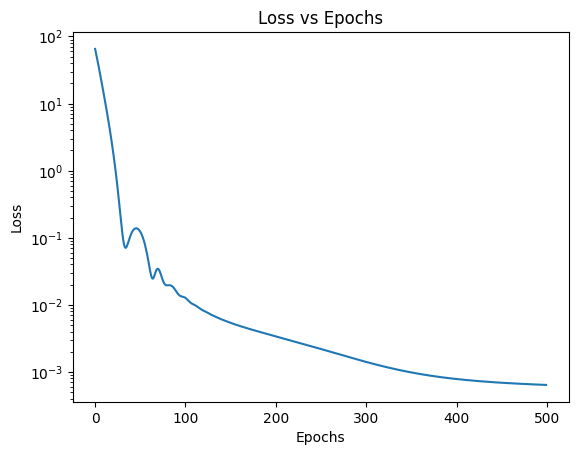

In [44]:
xf_stars = ks_sim.sim(lambdas, xf0, Theta_star)

lr = 1e-2
n_epochs = 500
schedule = optax.cosine_decay_schedule(init_value=lr, decay_steps=n_epochs, alpha=0.3)

jit_learn = jax.jit(
    lambda lambdas, xf0, xf_stars, params: nn_sim.learn(
        lambdas, xf0, xf_stars, params, optim=optax.adam(schedule), n_epochs=n_epochs
    )
)
final_params, L = jit_learn(lambdas, xf0, xf_stars, params)
final_xfs = nn_sim.sim(lambdas, xf0, final_params)

print("truth: ", xf_stars)
print("nn: ", final_xfs)

plt.plot(L)
plt.yscale("log")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

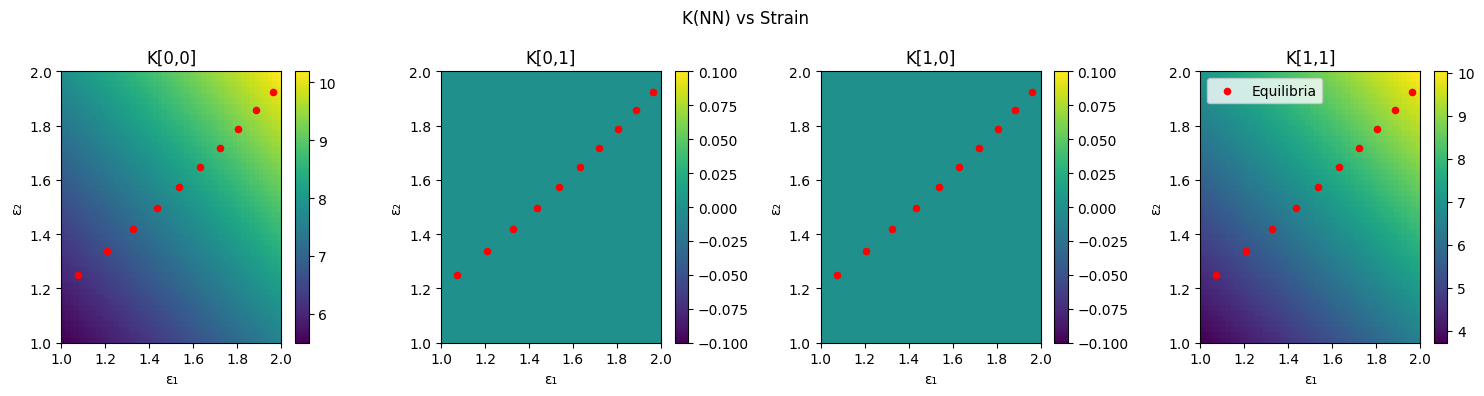

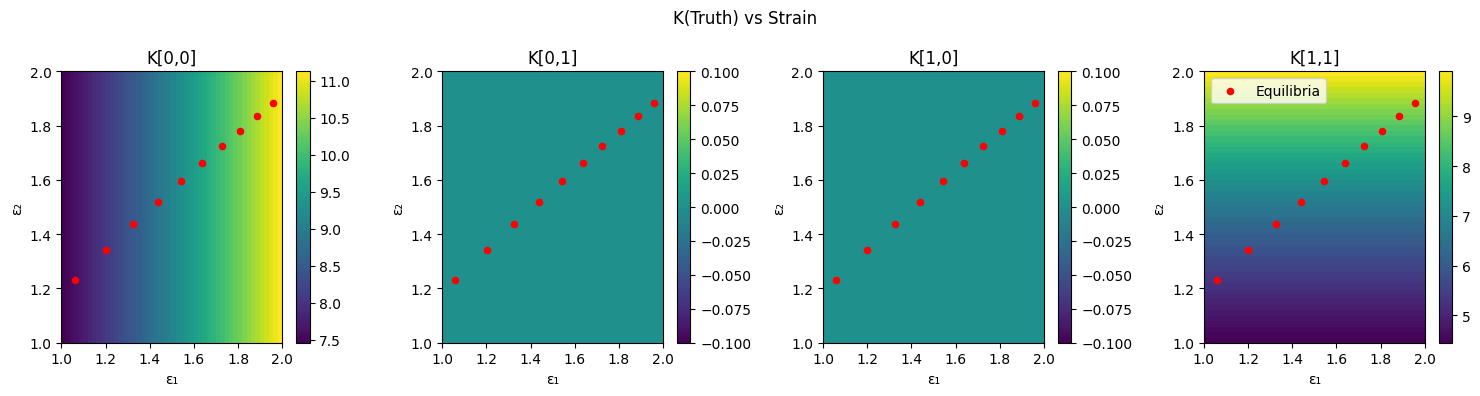

In [45]:
# Range of del_strains
del_strains = []
for (x1, x2) in final_xfs:
    del_strains.append(nn_energy.get_strain(0, x1, x2, nn_energy.l_k) - 1.0)
del_strains = jnp.stack(del_strains)

ks_del_strains = []
for (x1, x2) in xf_stars:
    ks_del_strains.append(ks_energy.get_strain(0, x1, x2, nn_energy.l_k) - 1.0)
ks_del_strains = jnp.stack(ks_del_strains)

# Get grid for heatmap
eps1_min, eps2_min = del_strains.min(0)
eps1_max, eps2_max = del_strains.max(0)
eps1 = jnp.linspace(jnp.floor(eps1_min), jnp.ceil(eps1_max), 50)
eps2 = jnp.linspace(jnp.floor(eps2_min), jnp.ceil(eps2_max), 50)
E1, E2 = jnp.meshgrid(eps1, eps2)
del_strains_map = jnp.stack([E1.ravel(), E2.ravel()], axis=-1)

# Generate map of Ks
nn_K = jax.vmap(lambda s: nn_energy.get_K(s, final_params))(del_strains_map)
ks_K = jax.vmap(lambda s: ks_energy.get_K(s, Theta_star))(del_strains_map)

def visualize_K(K, del_strains, suptitle = "K vs Strains"):
    K11 = K[:, 0, 0].reshape(E1.shape)
    K12 = K[:, 0, 1].reshape(E1.shape)
    K21 = K[:, 1, 0].reshape(E1.shape)
    K22 = K[:, 1, 1].reshape(E1.shape)

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    for ax, K, title in zip(
        axs, [K11, K12, K21, K22], ["K[0,0]", "K[0,1]", "K[1,0]", "K[1,1]"]
    ):
        im = ax.imshow(np.asarray(K), extent=(eps1.min(), eps1.max(), eps2.min(), eps2.max()),
                    origin='lower', cmap='viridis', aspect='auto')
        ax.set_xlabel("ε₁")
        ax.set_ylabel("ε₂")
        ax.scatter(del_strains[:, 0], del_strains[:, 1], color='red', s=20, marker='o', label='Equilibria')
        ax.set_title(title)
        fig.colorbar(im, ax=ax)
    fig.suptitle(suptitle)
    plt.legend()
    plt.tight_layout()
    plt.show()

visualize_K(nn_K, del_strains, "K(NN) vs Strain")
visualize_K(ks_K, ks_del_strains, "K(Truth) vs Strain")

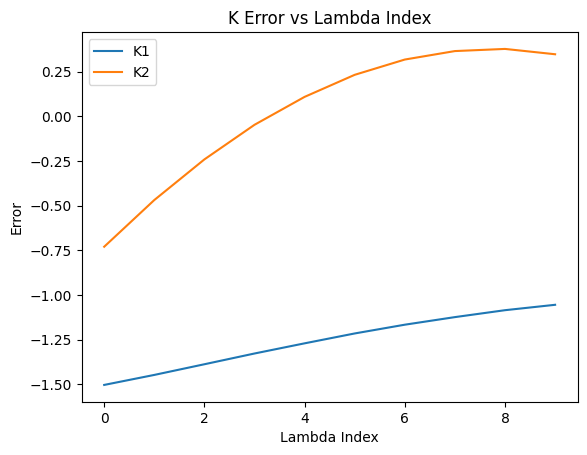

In [46]:
def visualize_K_diff(nn: NNTriplet, truth: Triplet, del_strains):
    error = jax.vmap(lambda s: nn.get_K(s, final_params) - truth.get_K(s, Theta_star))(del_strains)
    plt.plot(error[:, 0, 0], label="K1")
    plt.plot(error[:, 1, 1], label="K2")
    plt.legend()
    plt.title("K Error vs Lambda Index")
    plt.ylabel("Error")
    plt.xlabel("Lambda Index")
    plt.show()

visualize_K_diff(nn_energy ,ks_energy, del_strains)